In [145]:
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

### Modelling Economies with the Cobb-Douglas Production Function
A common method of modelling supply-side metrics in economics such as a company’s total production or a country’s GDP is the Cobb-Douglas function. This function can be manipulated and used as the basis of a
linear regression, which I will apply to the Penn World Table, a dataset that includes the various economic metrics of 183 countries between 1950 and 2019.

The Cobb-Douglas Production Functions models an economy's output as a function of two factors of production, capital and labor:
$$ Q = A\cdot K^\alpha \cdot L^\beta$$
Where Q represents output, K represents capital, and L represents labor and A,α,β are non-negative constant parameter.

#### Cleaning the data

In [146]:
pwt = pd.read_excel("pwt100.xlsx", sheet_name=2)

The dataset in question is version 10.0 of the Penn World Table. 5 The raw data is available as an
excel sheet with 12,811 entries each containing 51 different economic metrics. The table here is modified to include only the metrics relevant to this investigation (output, capital, and labor)

In [147]:
pwt = pwt[['country', 'year', 'rgdpe', 'cn', 'emp']]
pwt.dropna(inplace = True)

Expanding the dataframe to contain columns with the natural log of the raw data for clarity:

In [148]:
pwt[['logQ', 'logK', 'logL']] = np.log(pwt[['rgdpe', 'cn', 'emp']])

#### Constructing the model

Taking the natural log of both sides of the CD function allows for it to be used as the basis of a linear regression:
$$ln⁡Q=ln⁡(A⋅K^α⋅L^β)\\
⇔ln⁡Q=ln⁡(A)+ln⁡(K^α )+ln⁡(L^β )\\
⇔ln⁡Q=ln⁡(A)+α ln⁡(K)+β ln⁡(L)$$
Hence, the linear regression models the natural log of an economies output as a function of the natural log of capital and labor available in the economy



Separating training and test data:

In [149]:
shuffled_pwt = pwt.sample(frac=1)
pwt_train = shuffled_pwt.iloc[0: int(0.9 * len(shuffled_pwt))]
pwt_test = shuffled_pwt.iloc[int(0.9 * len(shuffled_pwt)):]

Fitting the model

In [150]:
model = LinearRegression()
model.fit(pwt_train[['logK', 'logL']], pwt_train[["logQ"]]);

#### Testing the model

In [151]:
logQ_predicted = model.predict(pwt_test[['logK', 'logL']])
r_square = r2_score(pwt_test['logQ'], logQ_predicted)

In [152]:
r_square

0.9578180007305263

The r^2 value of the model based on the training data is > 0.95, suggesting that the model performs extremely well on unseen data

In [153]:
rmse = np.sqrt(mean_squared_error(pwt_test['logQ'], logQ_predicted))
rmse_percentage = rmse / np.mean(pwt_test['logQ'])
rmse, rmse_percentage * 100

(0.44526371072823956, 4.190924882601943)

The root-mean-square-error for the model is approximately 0.45, or 4% of the mean value for logQ. This is acceptably low and indicates the model is considerably accurate

#### Coefficient Analysis

The coefficients of the linear model give us the corresponding values of log(A), alpha, and beta in the CD model:

In [154]:
A = np.exp(model.intercept_)[0]
alpha = model.coef_[0][0]
beta = model.coef_[0][1]

In the CD function, _A_ is a metric that represents the 'total factor productivity of an economy' (TFP), i.e how well an economy utilizes the available labor and capital. 

While the values of this paramter over the entire dataset don't give much insight, seeing the change in parameters over time tells us more about the global economy

By grouping the entire dataset by year, we can use the model that was just constructed to find the total factor productivity of the global economy at multiple periods in time, starting from 1950 up to 2019, and see the corresponding trend 

In [155]:
def get_tfp(df):
    A_coef = {}
    for i in df.groupby(by='year'):
        m = LinearRegression()
        year, d = i[0], i[1]
        m.fit(d[['logK', 'logL']], d[['logQ']])
        A_coef[year] = np.exp(m.intercept_)[0]
    return A_coef

global_productivity = get_tfp(pwt)

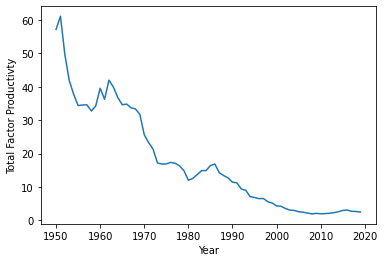

In [156]:
plt.plot(global_productivity.keys(), global_productivity.values())
plt.xlabel("Year")
plt.ylabel("Total Factor Productivty")
plt.show()

Interestingly, we see that total factor productivity declines over time. I'd expect an increase in productivity with advances in technology, but it seems that the world's productivity has declined over time

Doing the same with only data pertaining to the United States, we see starkly different results:

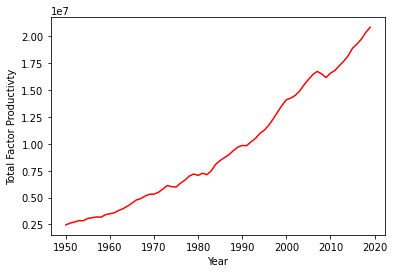

In [157]:
pwt_usa = pwt[pwt['country'] == 'United States']
USA_productivity = get_tfp(pwt_usa)

plt.plot(USA_productivity.keys(), USA_productivity.values(), 'r')
plt.xlabel("Year")
plt.ylabel("Total Factor Productivty")
plt.show()

Interestingly, we see that the US shows a significant rise in TFP, while the world as a whole declines. While there may be multiple factors for this, a possible explanation is that the benefits of scientific and technological advancements are primarily being reaped by a select few countries while the rest struggle to effectively